<a href="https://colab.research.google.com/github/Datawithabhishek/Fare-Amount-Prediction/blob/main/Fare_Amount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fare Amount Prediction**

# **Dependencies**

In [498]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler



import warnings
warnings.filterwarnings('ignore')

# **Load the Data**

In [389]:
df = pd.read_csv('https://raw.githubusercontent.com/Datawithabhishek/Fare-Amount-Prediction/main/trip.csv')

In [390]:
df.head()

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


# **Fields**

key - a unique identifier for each trip

fare_amount - the cost of each trip in usd

pickup_datetime - date and time when the meter was engaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

# **Understand the Data**

In [391]:
df.shape

(200000, 9)

In [392]:
df.isnull().sum()

index                0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [394]:
df.duplicated().sum()

0

#**Data Cleaning**

##Remove Null values

In [293]:
df.isnull().sum()

index                0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Some columns, such as dropoff_longitude and dropoff_latitude, contain null values as observed from the data.

In [395]:
df= df.dropna()

## Handle Wrong Data Format

In [403]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'].apply(lambda x :datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').date()))

In [406]:
df.drop(['key'],axis=1,inplace=True)

In [408]:
df['key']=df['index']

In [410]:
df.drop(['index'],axis=1,inplace=True)

In [411]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key
0,7.5,2015-05-07,-73.999817,40.738354,-73.999512,40.723217,1,24238194
1,7.7,2009-07-17,-73.994355,40.728225,-73.994710,40.750325,1,27835199
2,12.9,2009-08-24,-74.005043,40.740770,-73.962565,40.772647,1,44984355
3,5.3,2009-06-26,-73.976124,40.790844,-73.965316,40.803349,3,25894730
4,16.0,2014-08-28,-73.925023,40.744085,-73.973082,40.761247,5,17610152


## Handling Wrong Data

In [412]:
df['passenger_count'].unique()

array([  1,   3,   5,   2,   4,   6,   0, 208])

The values 0 and 208 are outliers in the data.

**0:** A car cannot operate without any person.

**208:** A single car cannot accommodate 208 passengers, even if it is an SUV.

In [413]:
df = df[df['passenger_count']!=0]

In [414]:
df = df[df['passenger_count']!=208]

In [415]:
df = df[df['passenger_count']<6]

In [416]:
df['passenger_count'].unique()

array([1, 3, 5, 2, 4])

In [417]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key
0,7.5,2015-05-07,-73.999817,40.738354,-73.999512,40.723217,1,24238194
1,7.7,2009-07-17,-73.994355,40.728225,-73.994710,40.750325,1,27835199
2,12.9,2009-08-24,-74.005043,40.740770,-73.962565,40.772647,1,44984355
3,5.3,2009-06-26,-73.976124,40.790844,-73.965316,40.803349,3,25894730
4,16.0,2014-08-28,-73.925023,40.744085,-73.973082,40.761247,5,17610152


In [418]:
df=df[df['fare_amount']>0]

True Range of latitude of longitude


**-90** to **90** for **latitude** and **-180** to **180** for **longitude**.

In [419]:
df = df[df['pickup_longitude']>=-180]

In [420]:
df = df[df['pickup_longitude']<=180]

In [421]:
df = df[df['dropoff_longitude']>=-180]

In [422]:
df = df[df['dropoff_longitude']<=180]

In [423]:
df = df[df['pickup_latitude']>=-90]

In [424]:
df = df[df['pickup_latitude']<=90]

In [425]:
df = df[df['dropoff_latitude']>=-90]

In [426]:
df = df[df['dropoff_latitude']<=90]

In [427]:
df.shape

(194985, 8)

# **Feature Engineering**

In [428]:
import numpy as np

def haversine_distance(p1, p2):
  """Calculates the Haversine distance between two points in kilometers.

  Args:
    p1: A tuple of two floats, representing the latitude and longitude of the first point.
    p2: A tuple of two floats, representing the latitude and longitude of the second point.

  Returns:
    A float representing the Haversine distance between the two points in kilometers.
  """

  earth_radius = 6371.01 # km

  lat1 = np.radians(p1[0])
  lon1 = np.radians(p1[1])
  lat2 = np.radians(p2[0])
  lon2 = np.radians(p2[1])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

  distance = earth_radius * c

  return distance

# Calculate the Haversine distance between the pickup and dropoff locations.
pickup_location = (df['pickup_longitude'].values, df['pickup_latitude'].values)
dropoff_location = (df['dropoff_longitude'].values, df['dropoff_latitude'].values)

df['distance'] = haversine_distance(pickup_location, dropoff_location)


In [429]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key,distance
0,7.5,2015-05-07,-73.999817,40.738354,-73.999512,40.723217,1,24238194,0.465182
1,7.7,2009-07-17,-73.994355,40.728225,-73.994710,40.750325,1,27835199,0.678729
2,12.9,2009-08-24,-74.005043,40.740770,-73.962565,40.772647,1,44984355,4.823529
3,5.3,2009-06-26,-73.976124,40.790844,-73.965316,40.803349,3,25894730,1.261641
4,16.0,2014-08-28,-73.925023,40.744085,-73.973082,40.761247,5,17610152,5.369911
...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28,-73.987042,40.739367,-73.986525,40.740297,1,42598914,0.064177
199996,7.5,2014-03-14,-73.984722,40.736837,-74.006672,40.739620,1,16382965,2.442223
199997,30.9,2009-06-29,-73.986017,40.756487,-73.858957,40.692588,2,27804658,14.264814
199998,14.5,2015-05-20,-73.997124,40.725452,-73.983215,40.695415,1,20259894,1.800097


In [430]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
key                  0
distance             0
dtype: int64

In [432]:
df = df[df['distance']<150]

In [433]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key,distance
count,194572.000000,194572.000000,194572.000000,194572.000000,194572.000000,194572.000000,1.945720e+05,194572.000000
mean,11.343733,-72.581087,39.959381,-72.580154,39.959664,1.595199,2.771238e+07,2.662657
std,9.883504,10.165793,5.962870,10.165691,5.963037,1.151455,1.601520e+07,3.914045
min,0.010000,-75.387785,-74.015515,-75.417737,-74.015750,1.000000,1.000000e+00,0.000000
25%,6.000000,-73.992068,40.734862,-73.991412,40.733934,1.000000,1.381903e+07,0.822250
50%,8.500000,-73.981847,40.752607,-73.980113,40.753073,1.000000,2.774550e+07,1.522757
75%,12.500000,-73.967247,40.767167,-73.963750,40.768027,2.000000,4.156456e+07,2.793454
max,499.000000,40.808425,45.031653,40.831932,45.031598,5.000000,5.542357e+07,117.541181


In [434]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key,distance
0,7.5,2015-05-07,-73.999817,40.738354,-73.999512,40.723217,1,24238194,0.465182
1,7.7,2009-07-17,-73.994355,40.728225,-73.994710,40.750325,1,27835199,0.678729
2,12.9,2009-08-24,-74.005043,40.740770,-73.962565,40.772647,1,44984355,4.823529
3,5.3,2009-06-26,-73.976124,40.790844,-73.965316,40.803349,3,25894730,1.261641
4,16.0,2014-08-28,-73.925023,40.744085,-73.973082,40.761247,5,17610152,5.369911


In [435]:
df['year']=df['pickup_datetime'].dt.year

In [436]:
df['Month'] = df['pickup_datetime'].dt.month
df['Date'] = df['pickup_datetime'].dt.day
df['Day'] = df['pickup_datetime'].dt.dayofweek


In [437]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key,distance,year,Month,Date,Day
0,7.5,2015-05-07,-73.999817,40.738354,-73.999512,40.723217,1,24238194,0.465182,2015,5,7,3
1,7.7,2009-07-17,-73.994355,40.728225,-73.994710,40.750325,1,27835199,0.678729,2009,7,17,4
2,12.9,2009-08-24,-74.005043,40.740770,-73.962565,40.772647,1,44984355,4.823529,2009,8,24,0
3,5.3,2009-06-26,-73.976124,40.790844,-73.965316,40.803349,3,25894730,1.261641,2009,6,26,4
4,16.0,2014-08-28,-73.925023,40.744085,-73.973082,40.761247,5,17610152,5.369911,2014,8,28,3


In [438]:
df.drop(['pickup_datetime','pickup_longitude',	'pickup_latitude',	'dropoff_longitude',	'dropoff_latitude'],axis=1,inplace=True)

In [439]:
df = df[['key','Date','Month','year','Day','distance','passenger_count','fare_amount']]

In [440]:
df['Date']=df['Date'].astype('int64')

In [441]:
df['Month']=df['Month'].astype('int64')

In [442]:
df['year']=df['year'].astype('int64')

In [443]:
df['Day']=df['Day'].astype('int64')

In [444]:
df = df[df['Day']>0]

In [445]:
df = df[df['distance']>0]

# **EDA**

### Number of Passengers effects the the fare

In [446]:
ax = df.groupby(['passenger_count'],as_index=False)['fare_amount'].mean().sort_values(by='fare_amount',ascending=False)

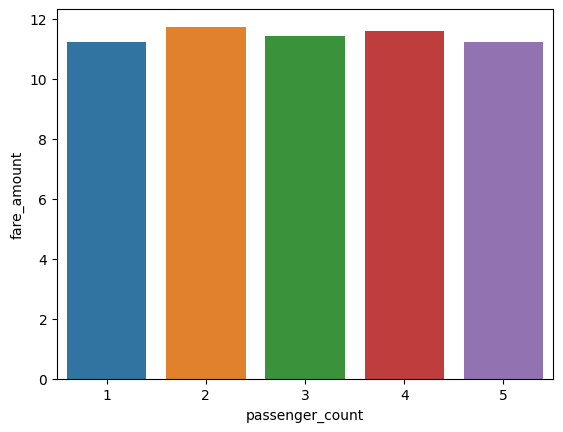

In [447]:
sns.barplot(x='passenger_count',y='fare_amount',data=ax)
plt.show()

### Pickup year and time effects the fare

In [448]:
vx = df.groupby(['year'],as_index=False)['fare_amount'].mean().sort_values(by='fare_amount',ascending=False)

In [449]:
vx = vx.set_index(['year'])


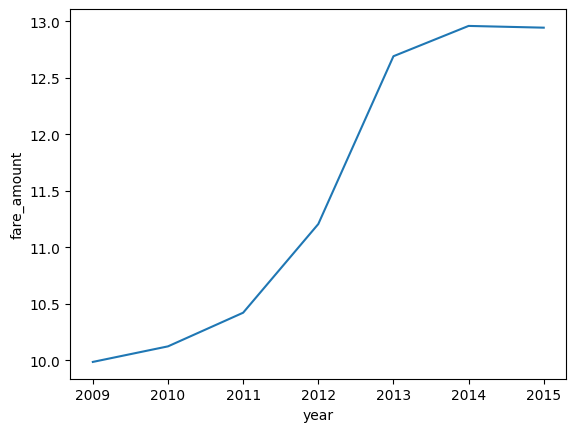

In [450]:
sns.lineplot(vx['fare_amount'])
plt.show()

### which month has the most traffic

In [451]:
cx =df.groupby(['Month'],as_index=False)['passenger_count'].sum().sort_values(by='passenger_count',ascending=False)

In [452]:
cx.head()

,Month,passenger_count
4,5,25150
2,3,24555
3,4,24228
0,1,23311
5,6,23301


### Distance effects the fare

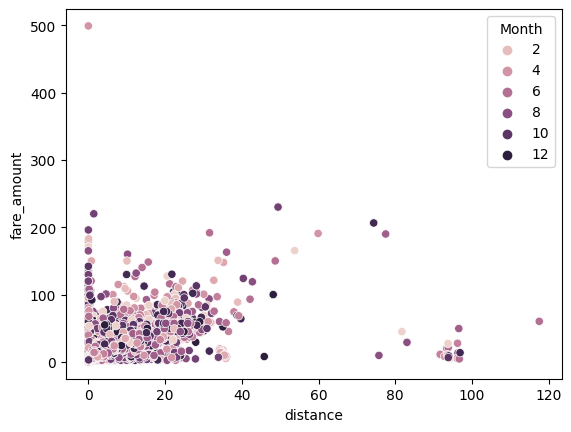

In [453]:
sns.scatterplot(x='distance',y='fare_amount',hue='Month',data=df)
plt.show()

### Check the distribution

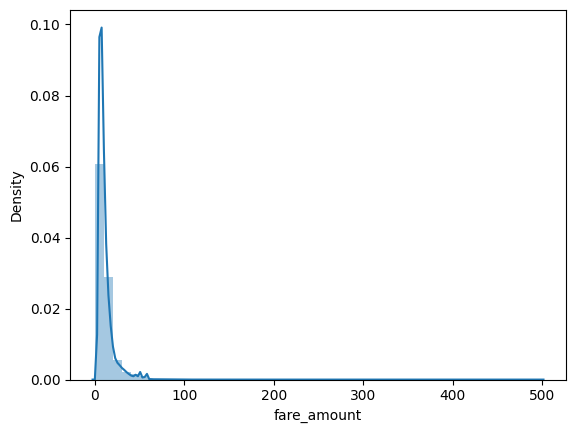

In [454]:
sns.distplot(df['fare_amount'])
plt.show()

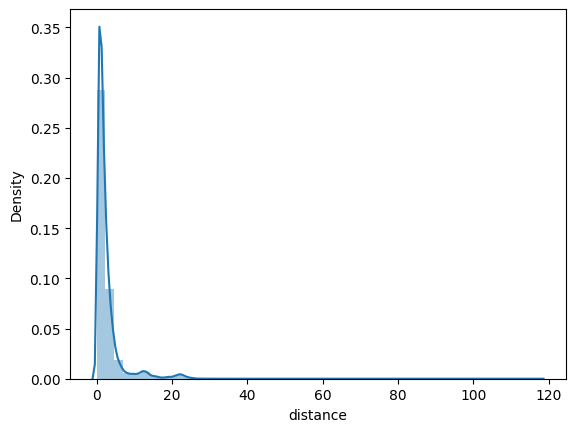

In [455]:
sns.distplot(df['distance'])
plt.show()

### Multicollinearity

<Axes: >

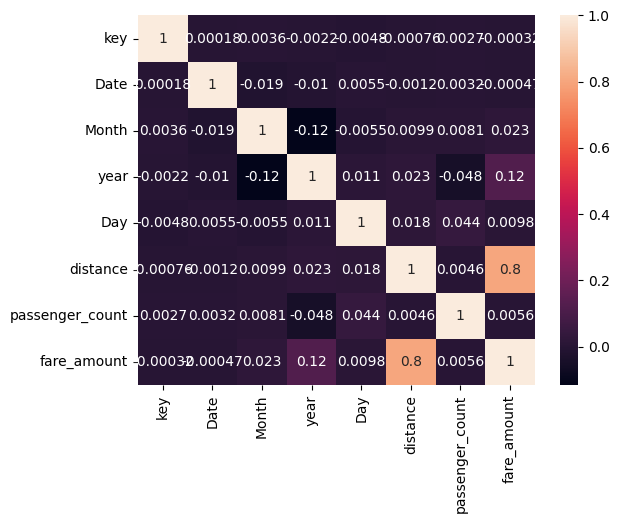

In [456]:
sns.heatmap(df.corr(),annot=True)

# **Data Preprocessing**

### Feature Scalling

In [457]:
df['distance'] = np.log1p(df['distance'])

In [458]:
df['fare_amount']= np.log1p(df['fare_amount'])

In [459]:
df.head()

,key,Date,Month,year,Day,distance,passenger_count,fare_amount
0,24238194,7,5,2015,3,0.381980,1,2.140066
1,27835199,17,7,2009,4,0.518037,1,2.163323
3,25894730,26,6,2009,4,0.816090,3,1.840550
4,17610152,28,8,2014,3,1.851585,5,2.833213
6,48725865,12,10,2014,6,2.428000,5,3.238678


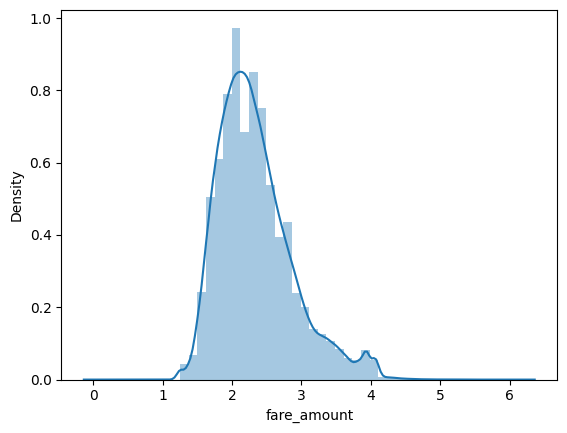

In [460]:
sns.distplot(df['fare_amount'])
plt.show()

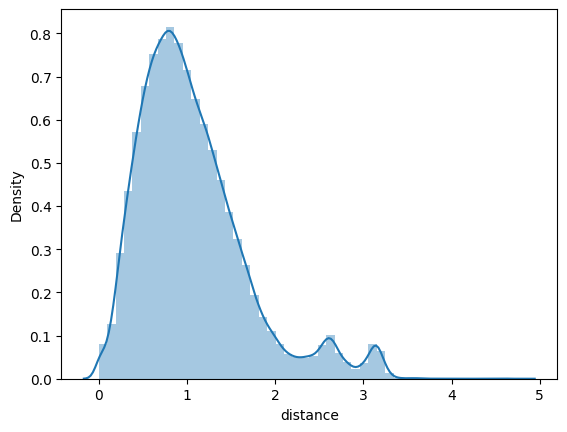

In [461]:
sns.distplot(df['distance'])
plt.show()

### Model Selection

In [462]:
x = df.iloc[:,:-1].values

In [463]:
y = df['fare_amount'].values

In [464]:
x_train,x_test,y_train,y_test  = train_test_split(x,y,test_size=0.2)

In [465]:
sc = StandardScaler()
x_train=sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# **Model**

#### Linear Regression

In [500]:
lr = LinearRegression(n_jobs=-1).fit(x_train,y_train)

In [501]:
pred_test_lr = lr.predict(x_test)

In [506]:
pred_test_lr

array([2.98316679, 3.57649659, 2.46129872, ..., 2.00644959, 2.63454667,
       2.03119754])

#### Xgboosting Regressor

In [486]:
xgb = XGBRegressor()
params ={'learning_rate':[0.01,0.1],'n_estimators':[300,500],'max_depth':[3,4]}
xgb_gid = GridSearchCV(xgb,params,scoring="neg_mean_squared_error",cv=5)
xgb_gid.fit(x_train,y_train)
xgb_gid.best_params_


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [489]:
xgb = XGBRegressor(learning_rate= 0.1, max_depth= 3, n_estimators= 300)

In [490]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [491]:
xgb_predict = xgb.predict(x_test)

In [510]:
xgb_predict

array([2.9049566, 3.5890083, 2.391726 , ..., 2.0365891, 2.6691415,
       2.0268953], dtype=float32)

# **Evaluation**

In [499]:
lr_mse = mean_squared_error(y_test,pred_test_lr)

In [505]:
lr_score = r2_score(y_test,pred_test_lr)

In [508]:
# Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
lr_adjust = 1 - (1-lr_score) * (len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

In [509]:
xgb_mse = mean_squared_error(y_test,xgb_predict)

In [511]:
xgb_score=r2_score(y_test,xgb_predict)

In [512]:
xgb_adjust = 1 - (1-xgb_score) * (len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

In [513]:
Report = pd.DataFrame(data={'model':['linear Regression','XGB Regression'],'Mean Squared Error':[lr_mse,xgb_mse],
                            'R2_Score':[lr_score,xgb_score],'Adjusted r2 score':[lr_adjust,xgb_adjust]})

In [514]:
Report

,model,Mean Squared Error,R2_Score,Adjusted r2 score
0,linear Regression,0.096985,0.661803,0.661785
1,XGB Regression,0.092133,0.678767,0.678750
